Deep Learning 
=============

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset, where the data is a lot less 'clean' than the MNIST dataset.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import urllib
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import cPickle as pickle
import shutil
import os

### Hyperparameter

In [2]:
url = 'http://yaroslavvb.com/upload/notMNIST/'
basket_static ='/mnt/basket/processingData/data/notMNIST'
basket_volatile = "/mnt/basket/processingData/volatile/notMNIST"
train_filename = "notMNIST_large.tar.gz"
test_filename = "notMNIST_small.tar.gz"
save_pickle_filename = "notMNIST.pickle"
test_filename_volatile = basket_volatile + "/notMNIST_small.tar.gz"

### Cleanup
Delete data from previous runs

In [3]:
# re-create the directory if it exists
if os.path.exists(basket_volatile):
    shutil.rmtree(basket_volatile)
    os.makedirs(basket_volatile)
else:
    os.makedirs(basket_volatile)

### Download two dataset

First download the dataset to the local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the test set 19000 labelled examples.

In [4]:
def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  storeFilename = os.path.join(basket_static,filename)
  if not os.path.exists(storeFilename):
    filename, _ = urllib.urlretrieve(url + filename, storeFilename)
  statinfo = os.stat(storeFilename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', storeFilename
  else:
    raise Exception(
      'Failed to verify' + storeFilename + '. Can you get to it with a browser?')
  return storeFilename

maybe_download(test_filename, 8458043)
maybe_download(train_filename, 247336696)

Found and verified /mnt/basket/processingData/data/notMNIST/notMNIST_small.tar.gz
Found and verified /mnt/basket/processingData/data/notMNIST/notMNIST_large.tar.gz


'/mnt/basket/processingData/data/notMNIST/notMNIST_large.tar.gz'

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [5]:
num_classes = 10 # A - J

def extract(filename):
  tar = tarfile.open(os.path.join(basket_static,filename))
  tar.extractall(basket_volatile)
  tar.close()
  root = os.path.splitext(os.path.splitext(os.path.join(basket_volatile,filename))[0])[0]  # remove .tar.gz
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_folders, len(data_folders)))
  return data_folders

test_folders = extract(test_filename)
train_folders = extract(train_filename)

### Feature scaling and load images

Now let's load the data in a more manageable format.

Convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, so just skip them.

Formular:    <b> (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth </b>

The <span style="color:green">subtraction of pixel_depth/2</span> <span style="color:red">centers the pixel values to be between [-pixel_depth/2, pixel_depth/2]</span>. The <span style="color:green">division by pixel_depth</span> then <span style="color:red">rescales the pixel values to be between [-0.5, 0.5]</span>.

For example, if <span style="color:green">pixel_depth = 10</span> , then all values are between <span style="color:green">[0,10]</span> . Subtracting all pixels by <span style="color:green">5</span>  shifts the values to <span style="color:green">[-5, 5]</span> . Dividing by <span style="color:green">10</span> , rescales the values to be <span style="color:green">[-0.5, 0.5]</span> .

It generally helps in machine learning to have all features on a similar scale ( called "Feature scaling"). It speeds up learning. 
The gradients point better to the minimum.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # RGB max value

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (num_images, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        ## normalize the image
        image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print 'Full dataset tensor:', dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  print 'Labels:', labels.shape
  return dataset, labels


train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)

del train_folders  # hint to help gc free up memory
del test_folders  # hint to help gc free up memory

/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/A
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/lib/python2.7/dist-packages/PIL/_binary.py", line 18, in i8
    return ord(c)
TypeError: ord() 

 /mnt/basket/processingData/volatile/notMNIST/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/lib/python2.7/dist-packages/PIL/_binary.py", line 18, in i8
    return ord(c)
TypeError: ord() 

 /mnt/basket/processingData/volatile/notMNIST/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: /mnt/basket/processingData/volatile/notMNIST/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/B

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/lib/python2.7/dist-packages/PIL/_binary.py", line 18, in i8
    return ord(c)
TypeError: ord() 


Could not read: /mnt/basket/processingData/volatile/notMNIST/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file '/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/C
/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/D

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/lib/python2.7/dist-packages/PIL/_binary.py", line 18, in i8
    return ord(c)
TypeError: ord() 


Could not read: /mnt/basket/processingData/volatile/notMNIST/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file '/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/E
/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/F
/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/G
/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/H
/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/I
/mnt/basket/processingData/volatile/notMNIST/notMNIST_large/J
Full dataset tensor: (529114, 28, 28)
Mean: -0.0816592
Standard deviation: 

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/lib/python2.7/dist-packages/PIL/_binary.py", line 18, in i8
    return ord(c)
TypeError: ord() 

0.454233
Labels: (529114,)
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/A
Could not read: /mnt/basket/processingData/volatile/notMNIST/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file '/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/B
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/C
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/D
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/E
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/F

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/lib/python2.7/dist-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/lib/python2.7/dist-packages/PIL/_binary.py", line 18, in i8
    return ord(c)
TypeError: ord() 


Could not read: /mnt/basket/processingData/volatile/notMNIST/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : cannot identify image file '/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png' - it's ok, skipping.
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/G
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/H
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/I
/mnt/basket/processingData/volatile/notMNIST/notMNIST_small/J
Full dataset tensor: (18724, 28, 28)
Mean: -0.0746362
Standard deviation: 0.458622
Labels: (18724,)


Verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. 

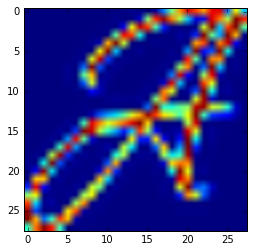

(529114,)
0


In [7]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[4])
plt.show()
print(train_labels.shape)
print(train_labels[4]) # 0=a, 1=b, 2=c ... 9=j

The image data doesn't have any colours encoded in it, it looks like that because of the horrible jet colormap (https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/). Try <b>plt.imshow(x, cmap="binary")</b> for a more natural look.

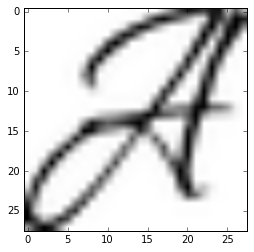

In [8]:
plt.imshow(train_dataset[4], cmap="binary")
plt.show()

## Shuffle distribution

Randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
np.random.seed(150)

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

Check if the data looks still good after shuffling

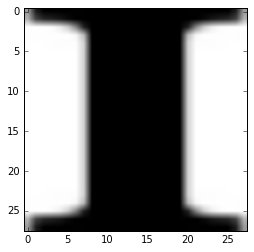

(529114,)
8


In [10]:
plt.imshow(train_dataset[4], cmap="binary")
plt.show()
print(train_labels.shape)
print(train_labels[4]) # 0=a, 1=b, 2=c ... 9=j

#### Additional way to print Images

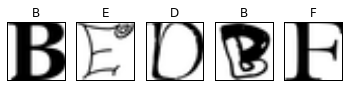

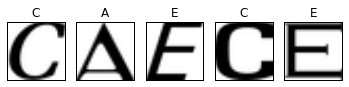

In [11]:
import random
%matplotlib inline
def showProcessedRandom(dataset,labels,n): # shows size of the sample
    indices=random.sample(range(0,labels.shape[0]),n)
    fig=plt.figure()
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        plt.imshow(dataset[indices[i],:,:], cmap="binary")
        a.set_title(chr(labels[indices[i]]+ord('A')))
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    plt.show()
    
showProcessedRandom(train_dataset,train_labels,5) 
showProcessedRandom(test_dataset,test_labels,5)

### Data histogram and bar chart

Check if the data is balanced across classes

In [12]:
def calc_balance_of_classes(labels):
  classBalance=[0,0,0,0,0,0,0,0,0,0]
  for vimg in labels:
    if vimg == 0:
        classBalance[0] = classBalance[0]+1
    if vimg == 1:
        classBalance[1] = classBalance[1]+1
    if vimg == 2:
        classBalance[2] = classBalance[2]+1
    if vimg == 3:
        classBalance[3] = classBalance[3]+1
    if vimg == 4:
        classBalance[4] = classBalance[4]+1
    if vimg == 5:
        classBalance[5] = classBalance[5]+1
    if vimg == 6:
        classBalance[6] = classBalance[6]+1
    if vimg == 7:
        classBalance[7] = classBalance[7]+1
    if vimg == 8:
        classBalance[8] = classBalance[8]+1
    if vimg == 9:
        classBalance[9] = classBalance[9]+1
  print("train_lables.shape: " , labels.shape)
  print("classBalance: " , classBalance)
  print("np.sum(classBalance): " , np.sum(classBalance))
  return classBalance

In [13]:
def draw_bar_diagram_1(classBalance):
    _classes = ['a','b','c','d','e','f','g','h','i','j']
    y_pos = np.arange(len(_classes))
    plt.bar(y_pos, classBalance, align='center', alpha=0.5)
    plt.xticks(y_pos, _classes)
    plt.ylabel('Occurance')
    plt.xlabel('Classes')
    plt.title('Balenced training set')
    plt.show()
    del classBalance

('train_lables.shape: ', (529114,))
('classBalance: ', [52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911])
('np.sum(classBalance): ', 529114)


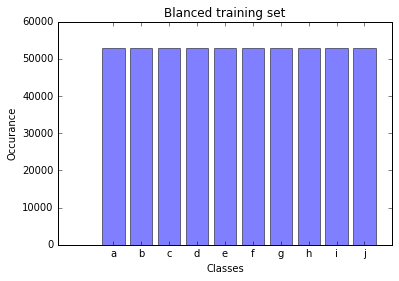

In [14]:
classBalance = calc_balance_of_classes(train_labels)
draw_bar_diagram_1(classBalance)

(529114,)


(array([ 52909.,  52911.,  52912.,  52911.,  52912.,  52912.,  52912.,
         52912.,  52912.,  52911.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

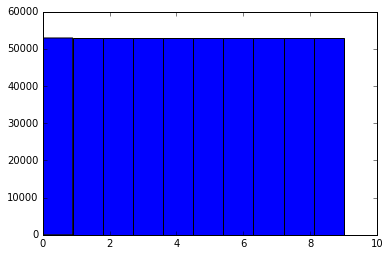

In [15]:
print(train_labels.shape)
plt.hist(train_labels, bins=10) 

## Create training, testing, validation dataset

We have two zip files downloaded, "notMNIST_small.zip" and "notMNIST_large.zip" <br>
The training dataset is filled with images of "notMNIST_large.zip" , which contains > 500k images. <br>
The testing dataset is filled out of  "notMNIST_small.zip" which contains > 200k images. <br> <br>

Now we create an additionaly validation dataset. This dataset will contain 10 % of the training dataset. <br> <br>

Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

In [16]:
train_size = int(train_labels.shape[0] * 0.9)  # 90 %
valid_size = int(train_labels.shape[0] * 0.1)  # 10 %

#slice [start:stop:step]
part_valid_dataset = train_dataset[:valid_size,:,:]
part_valid_labels = train_labels[:valid_size]
part_train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
part_train_labels = train_labels[valid_size:valid_size+train_size]

print 'Training', part_train_dataset.shape[0]
print 'Testing',  test_dataset.shape[0]
print 'Validation', part_valid_dataset.shape[0]

Training 476202
Testing 18724
Validation 52911


Draw distribution of classes

('train_lables.shape: ', (476202,))
('classBalance: ', [47630, 47660, 47687, 47525, 47732, 47689, 47562, 47604, 47578, 47535])
('np.sum(classBalance): ', 476202)


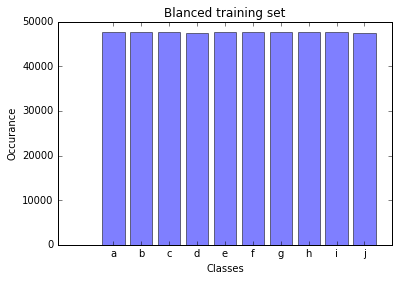

In [17]:
classBalance = calc_balance_of_classes(part_train_labels)
draw_bar_diagram_1(classBalance)

('train_lables.shape: ', (52911,))
('classBalance: ', [5279, 5251, 5225, 5386, 5180, 5222, 5350, 5308, 5334, 5376])
('np.sum(classBalance): ', 52911)


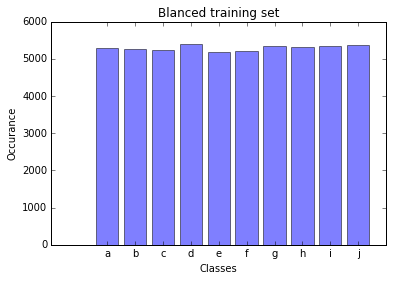

In [18]:
classBalance = calc_balance_of_classes(part_valid_labels)
draw_bar_diagram_1(classBalance)

### Save the datasets to disk

In [19]:
pickle_file = os.path.join(basket_volatile,save_pickle_filename)

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': part_train_dataset,
    'train_labels': part_train_labels,
    'valid_dataset': part_valid_dataset,
    'valid_labels': part_valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [20]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size

Compressed pickle size: 1720208621
